# Machine learning for biology, part four

How do we reliably score our k-nearest neighbors classifier?

Cross-validation allows us to systematically split our data into testing and training sets.

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
df = df.dropna()

In [38]:
#Randomize row order
df = df.sample(frac=1)
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
303,Chinstrap,Dream,49.5,19.0,200.0,3800.0,male,2008
239,Gentoo,Biscoe,51.3,14.2,218.0,5300.0,male,2009
141,Adelie,Dream,40.6,17.2,187.0,3475.0,male,2009
146,Adelie,Dream,39.2,18.6,190.0,4250.0,male,2009
34,Adelie,Dream,36.4,17.0,195.0,3325.0,female,2007


In [39]:
#Divide data into 5 chunks
chunk_size = int(len(df) / 5)
chunks = [df.iloc[i:i+chunk_size] for i in range(0, chunk_size * 5, chunk_size)]

In [40]:
def classify_penguin(bill_length, flipper_length, k, data):
    bill_length_difference = data['bill_length_mm'] - bill_length
    flipper_length_difference = data['flipper_length_mm'] - flipper_length
    overall_distance = np.sqrt(flipper_length_difference ** 2 + bill_length_difference ** 2)
    data['distance to new point'] = overall_distance

    most_common_species_nearby = data.sort_values('distance to new point').head(k)['species'].mode()[0]

    return most_common_species_nearby


In [41]:
def score_single_chunk(testing_chunk, training_chunks, k):
    # the training data is made up of chunks 2,3,4,5
    training_data = pd.concat(training_chunks)

    predictions = testing_chunk.apply(
            lambda p : 
                classify_penguin(p['bill_length_mm'], p['flipper_length_mm'], k, training_data)
            , axis=1
        )

    score = (predictions == testing_chunk['species']).value_counts(normalize=True)[True]
    return score

We take turns using each chunk as the testing set (with the rest of the chunks as the training set).

In [42]:
scores = []
for i in range(5):
    scores.append(score_single_chunk(chunks[i], chunks[0:i] + chunks[i+1:5], 10))

Then we take the average of these scores to measure the performance of our classifier.

In [43]:
np.mean(scores)

0.9393939393939394

Now, we use our cross-validation function to choose the best value for k.

In [44]:
k_scores = []
for k in range(1, 10):
    scores = []
    for i in range(5):
        scores.append(score_single_chunk(chunks[i], chunks[0:i] + chunks[i+1:5], k))
    k_scores.append([k, np.mean(scores)])

k_scores_df = pd.DataFrame(data=k_scores, columns=['k', 'score'])

In [45]:
k_scores_df

,k,score
0,1,0.930303
1,2,0.930303
2,3,0.960606
3,4,0.957576
4,5,0.957576
5,6,0.957576
6,7,0.951515
7,8,0.942424
8,9,0.945455


<AxesSubplot:xlabel='k', ylabel='score'>

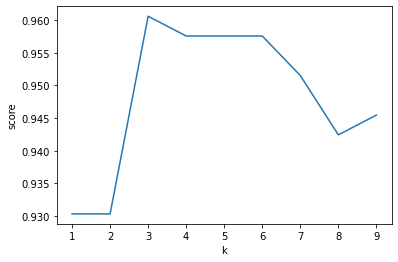

In [46]:
sns.lineplot(x='k', y='score', data=k_scores_df)